In [1]:
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
import torch
from tqdm import tqdm_notebook
import time
from torch.autograd import Variable
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

In [2]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [3]:
transform = torchvision.transforms.Compose([
    transforms.ToTensor()
])

In [4]:
train_dataset = torchvision.datasets.MNIST('../datasets/', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST('../datasets/', train=False, transform=transform, download=False)

In [5]:
train = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=100, num_workers=2)
val = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, num_workers=2)

In [6]:
def train_evaluate_model(model, train_loader, test_loader, gpu=False):
    num_epochs = 100 # total amount of full passes over training data
    batch_size = 100  # number of samples processed in one SGD iteration
    
    opt = torch.optim.Adam(model.parameters())

    train_loss = []
    val_accuracy = []
    

    for epoch in tqdm_notebook(range(num_epochs)):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
#         print(X_train.shape, y_train.shape)
        for X_batch, y_batch in train_loader:
            # train on batch
            loss = compute_loss(model, X_batch, y_batch, gpu=gpu)
            loss.backward()
            opt.step()
            opt.zero_grad()
            if gpu:
                train_loss.append(loss.item())
            else:
                train_loss.append(loss.item())

        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
#         print(X_val.shape, y_val.shape)
        for X_batch, y_batch in test_loader:
            if gpu:
                logits = model(Variable(torch.FloatTensor(X_batch).cuda()))
                y_pred = logits.argmax(1)
            else:
                logits = model(Variable(torch.FloatTensor(X_batch)))
                y_pred = logits.argmax(1)
            cur_acc = (y_batch == y_pred).double().mean()
            val_accuracy.append(cur_acc)
            

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(train_loader.dataset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(test_loader.dataset) // batch_size :]) * 100))

In [7]:
model = nn.Sequential(*[
    Flatten(),
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
])

In [ ]:
train_evaluate_model(model, train, val)

In [ ]:
torch.save(model.state_dict(), './mnist_pretrained.pt')

In [8]:
model.load_state_dict(torch.load('./mnist_pretrained.pt'))

In [9]:
from whitebox.whitebox import attack_optim
from whitebox.whitebox import attack_fastgrad

In [10]:
noise = attack_fastgrad(model, *test_dataset[0], verbose=True).squeeze()
noise_optim = attack_optim(model, *test_dataset[0], 3).squeeze()

Prediction before the attack: 7
Prediction after the attack: 3


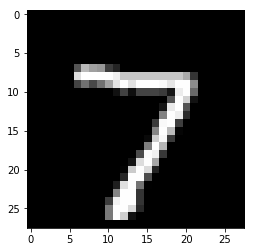

In [11]:
plt.imshow(test_dataset[0][0].squeeze(), cmap=plt.cm.gray)
plt.show()

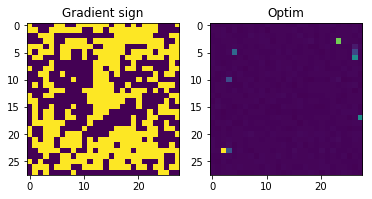

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(noise)
ax1.set_title('Gradient sign')
ax2.imshow(noise_optim)
ax2.set_title('Optim')
plt.show()

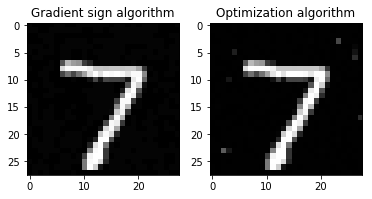

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(test_dataset[0][0].squeeze() + noise, cmap=plt.cm.gray)
ax1.set_title('Gradient sign algorithm')
ax2.imshow(test_dataset[0][0].squeeze() + noise_optim, cmap=plt.cm.gray)
ax2.set_title('Optimization algorithm')
plt.show()